# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Оглавление
1. [Шаг 1. Откройте файл с данными и изучите общую информацию](#step1)  
    1.1 [Вывод к Шагу 1](#step1.1)
    
        
2. [Шаг 2. Предобработка данных](#step2)  
    2.1   [Замена типов данных](#step2.1)  
    2.2   [Вывод к Шагу 2](#step2.2)  
  
    
3. [Шаг 3. Посчитайте и добавьте в таблицу](#step3)  
    3.1   [Вывод к Шагу 2](#step3.1)   
  
    
    
4. [Шаг 4. Проведите исследовательский анализ данных и выполните инструкции](#step4)  
    4.1   [Уберём редкие и выбивающиеся значения](#step4.1)  
    4.2   [Вывод к Шагу 4.2](#step4.1)  
    4.3   [Факторы, влияющие на стоимость квартиры](#step4.3)  
    4.4   [Вывод к Шагу 4.3](#step4.4)  
    4.5   [10 населенных пунктов с наибольшим числом объявлений](#step4.5)   
    4.6   [Исследование объявлений в Санкт-Петербурге](#step4.6)  
    4.7   [Вывод к Шагу 4](#step4.7)      
    
    
5. [Шаг 5. Общий вывод](#step5)  

### Шаг 1. Откройте файл с данными и изучите общую информацию. <a id="step1"></a>   
</div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.info()
print(data.head(10)) #выведем 10 верхних значений


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

In [2]:
data.columns # проверяем названия столбцов

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

### Вывод<a id="step1.1"></a>   
</div>  

В датасете данные по 23699 объектам недвижимости.  
Есть ряд пропущенных значений, которые будут влиять на ход исследования и их необходимо обработать. Возможно, что у части данных можно изменить тип для экономии памяти. 

### Шаг 2. Предобработка данных<a id="step2"></a>   
</div>  

In [3]:
print(data.isnull().sum()) #проверяем количество пропущенных значений

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


Нулевые значения присутствуют в ряде стобцов  
1. От пропуска в высоте потолков избавиться нельзя, слишком большое количество, будем подбирать медианные значения в зависимости от этажности дома. Решение неидеальное, но многие жилые дома строятся по типовым решениям, от этого и будем отталкиваться.
2. Число этажей - 86 ячеек. Не так много, поэтому эти ячейки обнулим. В будущем эти данные можно заполнять автоматически, используя адрес дома.  
3. Жилая площадь - пропущено до 10% ячеек, поэтому изучим эти столбцы подробнее, возможно, сможем на основании остальных данных заполнить эти ячейки.
4. Апартаметы или нет. Хотя в описании к заданию данный столбец описывается как булев, фактически он object, поэтому проведем замену типа и пропуски уйдут.  
5. С площадью кухни попробуем поступить по аналогии с жилой площадью.
6. Нулевое значение балконов скорее всего говорит об их отсутствии, то есть площадь равна 0.
7. Данные без населенного пункта удалим, так как их не так много. 
8. Нулевые данные для ближайших городов, аэропортов, парков, водоёмы, а также расстояния до них оставим без изменений, так как адекватного способа заполнения этих значений нет. Мы должны знать адрес объекта, чтобы внести данные, при этом пропуски составляют от 25% до 60% процентов для разных столбцов, медианные значения создадут слишком много "синтетических" данных.
9. Для отсутствующих значений по длительности размещения подставим медианные. 


In [4]:
# Посмотрим уникальные значения в 'ceiling_height', 'floor', 'open_plan')
data[['ceiling_height', 'floor', 'open_plan']].apply(lambda x: x.value_counts()).T.stack() 

# Обнаружилась проблема с очень большими и очень маленьким потолками





ceiling_height  1.0          1.0
                1.2          1.0
                1.75         1.0
                2.0         11.0
                2.2          1.0
                          ...   
floor           31.0         1.0
                32.0         1.0
                33.0         1.0
open_plan       False    23632.0
                1.0         67.0
Length: 218, dtype: float64

In [5]:
# Создадим сводную таблицу, где будут медианы для домов каждой этажности и их количество
ceiling_height_medians = data.pivot_table(index='floors_total', values='ceiling_height', aggfunc=['median', 'count'])
ceiling_height_medians.columns = ['median', 'count']
ceiling_height_medians.tail(10)

,median,count
floors_total,,
27.0,2.70,72
28.0,2.60,9
29.0,2.60,1
33.0,NaN,0
34.0,2.65,1
35.0,2.70,8
36.0,14.85,2
37.0,1.75,1
52.0,2.65,1


In [6]:
# Так как есть отсутсвующие значения для медиан по этажности, то заменяем их на общую медиану для всего датасета
for floor in ceiling_height_medians.index:
    data.loc[(data['floors_total'].isna()) | 
             ((data['floors_total'] == floor) & (ceiling_height_medians.loc[floor, 'count'] == 0)), 
             'ceiling_height'] = data['ceiling_height'].describe()[5]

# В зависимости от этажа вставим медианные значения для потолков
for floor in ceiling_height_medians.index:
    data.loc[(data['ceiling_height'].isna()) & 
             (data['floors_total'] == floor), 
             'ceiling_height'] = ceiling_height_medians.loc[floor, 'median']

# проверим есть ли еще нулевые потолки
data['ceiling_height'].isna().value_counts() # 


False    23699
Name: ceiling_height, dtype: int64

Жилая площадь (как и площадь кухни) на практике имеют зависимость не только от общей площади квартиры, но ещё от количества комнат, типа жилья (апартаменты, квартиры), класса (эконом, комфорт, бизнес), планировки, самим определением понятия жилой площади, а еще форматом жилья (обычный или евро), поэтому чтобы не усложнять заменим пропущенные значения только с привязкой к общей площади, предварительно округлив её до целых значений.



In [7]:
living_area_medians = data.pivot_table(index='total_area', values='living_area', aggfunc=['median', 'count'])
living_area_medians.columns = ['median', 'count']
living_area_medians.head(10)

,median,count
total_area,,
12.0,10.0,1
13.0,10.0,1
13.2,NaN,0
14.0,11.0,1
15.0,NaN,0
15.5,10.0,1
16.0,13.0,1
17.0,12.5,2
17.2,NaN,0


In [8]:
# Так как есть отсутсвующие значения для медиан по общей площади, то заменяем их на общую медиану для всего датасета
for total_area in living_area_medians.index:
    data.loc[(data['total_area'].isna()) | 
             ((data['total_area'] == total_area) & (living_area_medians.loc[total_area, 'count'] == 0)), 
             'living_area'] = data['living_area'].describe()[5]

# В зависимости от общей площади найдем медианные значения жилой площади
for total_area in living_area_medians.index:
    data.loc[(data['living_area'].isna()) & 
             (data['total_area'] == total_area), 
             'living_area'] = living_area_medians.loc[total_area, 'median']

# проверим есть ли ещё квартиы без жилой площади
data['living_area'].isna().value_counts() 

False    23699
Name: living_area, dtype: int64

In [9]:
kitchen_area_medians = data.pivot_table(index='total_area', values='kitchen_area', aggfunc=['median', 'count'])
kitchen_area_medians.columns = ['median', 'count']
kitchen_area_medians.head(10)

,median,count
total_area,,
12.0,NaN,0
13.0,NaN,0
13.2,NaN,0
14.0,2.0,1
15.0,NaN,0
15.5,NaN,0
16.0,NaN,0
17.0,3.0,1
17.2,NaN,0


In [10]:
# Так как есть отсутсвующие значения для медиан по общей площади, то заменяем их на общую медиану для всего датасета
for total_area in kitchen_area_medians.index:
    data.loc[(data['total_area'].isna()) | 
             ((data['total_area'] == total_area) & (kitchen_area_medians.loc[total_area, 'count'] == 0)), 
             'kitchen_area'] = data['kitchen_area'].describe()[5]

# В зависимости от площади вставим медианые значения
for total_area in living_area_medians.index:
    data.loc[(data['kitchen_area'].isna()) & 
             (data['total_area'] == total_area), 
             'kitchen_area'] = kitchen_area_medians.loc[total_area, 'median']

# проверим есть ли еще квартиры бещ площади кухни
data['kitchen_area'].isna().value_counts() 

False    23699
Name: kitchen_area, dtype: int64

In [11]:
# Подставим медианные значения для времени размещения просто по столбцу, так как попытка привязать их к какой-то другой категории не несёт в себе никакого смысла
data.loc[data['days_exposition'].isna(), 'days_exposition'] = data['days_exposition'].describe()[5]

In [12]:
# Уберём нулевые строки для 'floors_total' и 'locality_name'
data.dropna(subset=['floors_total'], inplace=True)
data.dropna(subset=['locality_name'], inplace=True)

# Заполним отсутсвующие значения балконов на нули и проверим всё ли получилось
data['balcony'].fillna(0, inplace=True)
data['balcony'].isna().value_counts()

False    23565
Name: balcony, dtype: int64

In [13]:
# По аналогии поступим и с расстоянием до центра города
cityCenters_nearest_medians = data.pivot_table(index='locality_name', values='cityCenters_nearest', aggfunc=['median', 'count'])
cityCenters_nearest_medians.columns = ['median', 'count']
cityCenters_nearest_medians.head(10)

for locality_name in cityCenters_nearest_medians.index:
    data.loc[(data['locality_name'].isna()) | 
             ((data['locality_name'] == locality_name) & (cityCenters_nearest_medians.loc[locality_name, 'count'] == 0)), 
             'cityCenters_nearest'] = data['cityCenters_nearest'].describe()[5]

# В зависимости от города заменим пропуски
for locality_name in cityCenters_nearest_medians.index:
    data.loc[(data['cityCenters_nearest'].isna()) & 
             (data['locality_name'] == locality_name), 
             'cityCenters_nearest'] = cityCenters_nearest_medians.loc[locality_name, 'median']

# проверим есть ли еще пропуски
data['cityCenters_nearest'].isna().value_counts() 



/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/pivot.py:56: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return concat(pieces, keys=keys, axis=1)


False    23565
Name: cityCenters_nearest, dtype: int64

In [14]:
# Проведём проверку наших действий
data.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment            20805
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5524
cityCenters_nearest         0
parks_around3000         5500
parks_nearest           15535
ponds_around3000         5500
ponds_nearest           14529
days_exposition             0
dtype: int64

### Замена типов данных<a id="step2.1"></a>   
</div>  

In [15]:
# Переведем 'is_apartment' в булевый тип

data.loc[data['is_apartment'].isna(), 'is_apartment'] = 0
data['is_apartment'] = data['is_apartment'].astype('bool')
print(data['is_apartment'].value_counts())

# Переведем дату публикации в datetime
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data.head(5)

False    23515
True        50
Name: is_apartment, dtype: int64


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,...,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,95.0
1,7,3350000.0,40.4,2018-12-04,1,2.75,11.0,18.6,1,False,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,2.55,5.0,34.3,4,False,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,2.60,14.0,95.0,9,False,...,15.0,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,...,41.0,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [16]:
#Проверим типы переменных

data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23565 non-null int64
last_price              23565 non-null float64
total_area              23565 non-null float64
first_day_exposition    23565 non-null datetime64[ns]
rooms                   23565 non-null int64
ceiling_height          23565 non-null float64
floors_total            23565 non-null float64
living_area             23565 non-null float64
floor                   23565 non-null int64
is_apartment            23565 non-null bool
studio                  23565 non-null bool
open_plan               23565 non-null bool
kitchen_area            23565 non-null float64
balcony                 23565 non-null float64
locality_name           23565 non-null object
airports_nearest        18041 non-null float64
cityCenters_nearest     23565 non-null float64
parks_around3000        18065 non-null float64
parks_nearest           8030 non-null float64
ponds_ar

### Вывод<a id="step2.2"></a>   
</div>    


Таким образом, мы избавились от всех значащих для решения поставленных вопрос пропусков.
В большинстве случаев, были применен принцип замены пропущенных значений через медианные (зависимости от того, можно ли выявить однозначную взаимосвязь с другим столбцом).  

К столбцам с малым количеством пропусков мы подошли более радикально, так как количество пропусков меньше 1%, мы просто избавились от них методом `dropna`.  

Для оптимизации памяти и соответствия заданию изменили тип переменной `is_apartment` на `bool`, а данные в `first_day_exposition` представили в формате `datetime`, что пригодится нам в дальнейшем добавлении данных в таблицу.

Пропуски в `airports_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest` оставили нетронутыми, так как адекватного метода их замены нет, а на дальнейшее выполнение задания они не влияют.  Их природа скорее всего связана с тем, что это не самые основные показатели квартиры.   
Часть пропусков в таких столбцах, как `balcony, is_apartment` связаны с тем, что при заполнении поле оставляли пустым (при его фактически нулевом значении).  
Пропуски `living_area и kitchen_area` могут быть связаны с тем, что часть людей могут быть не уверены в том, как определять эти величины, а отсутсвие значений в `ceiling_height` также может быть связано с человеческим фактором. Пропуски в `cityCenters_nearest` можно легко определять автоматически, в зависимости от адреса продаваемого объекта.

### Шаг 3. Посчитайте и добавьте в таблицу<a id="step3"></a>   
</div>  

Добавляем в таблицу стоимость одного квадратного метра (округлив до целых)

In [17]:
data['price_per_sqm'] = round(data['last_price'] / data['total_area'], 0)

Добавляем в таблицу день недели, месяц и год

In [18]:
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

Добавляем категории для этажей (первый, последний и другой)

In [19]:
data.loc[data['floor'] == 1, 'floor_category'] = 'первый'
data.loc[data['floor'] == data['floors_total'], 'floor_category'] = 'последний'
data.loc[data['floor_category'].isna(), 'floor_category'] = 'другой'

Добавляем соотношение жилой и общей площади, и отношение площади кухни и общей

In [20]:
data['living_area_ratio'] = round(data['living_area'] / data['total_area'], 3)
data['kitchen_area_ratio'] = round(data['kitchen_area'] / data['total_area'], 3)



In [21]:
#Проверям всё ли на месте 
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_per_sqm,weekday,month,year,floor_category,living_area_ratio,kitchen_area_ratio
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,...,2.0,755.0,95.0,120370.0,3,3,2019,другой,0.472,0.231
1,7,3350000.0,40.4,2018-12-04,1,2.75,11.0,18.6,1,False,...,0.0,NaN,81.0,82921.0,1,12,2018,первый,0.460,0.272
2,10,5196000.0,56.0,2015-08-20,2,2.55,5.0,34.3,4,False,...,2.0,574.0,558.0,92786.0,3,8,2015,другой,0.612,0.148
3,0,64900000.0,159.0,2015-07-24,3,2.60,14.0,95.0,9,False,...,3.0,234.0,424.0,408176.0,4,7,2015,другой,0.597,0.094
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,...,1.0,48.0,121.0,100000.0,1,6,2018,другой,0.320,0.410


### Вывод <a id="step3.1"></a>   
</div>  

В таблицу добавлены все необходимые для дальнейшего исследования данные: цена квадратного метра; день недели, месяц и год публикации объявления; этаж квартиры (с категоризации: первый, последний, другой); соотношения жилой и общей площади, а также отношение площади кухни к общей.

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции: <a id="step4"></a>   
</div>

Напишем функцию, которую будем в дальнейшем использовать для нахождения аномальных значений. В её основу заложим правила нормального размаха, которое определяется "усами"

In [22]:
def whiskers_position(column):
    stat = data[column].describe()
    # Найдём межквартальный размах
    iqr = stat[6] - stat[4]
    
    # Найдём левый и правый "ус"    
    left_whisker = round(stat[4] - 1.5 * iqr, 2)
    right_whisker = round(stat[6] + 1.5 * iqr, 2)

      
    return [left_whisker, right_whisker]

1. Изучаем параметры, начнем с площади квартир

count    23565.000000
mean        60.322824
std         35.657060
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64


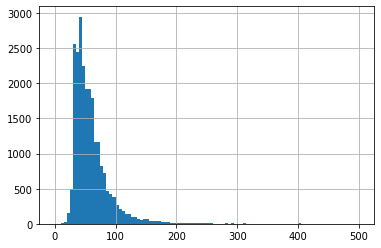

In [23]:
print(data['total_area'].describe())
data['total_area'].hist(bins = 100, range = (0,500))



(10, 150)

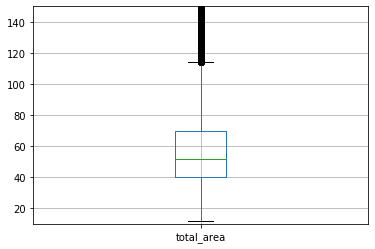

In [24]:
data.boxplot(column='total_area')

plt.ylim(10,150)

Добавим новый столбец, который описывает аномально большую площадь. Минимальная площадь в 12 кв. м тоже выглядит подозрительно, но это может быть студия.

In [25]:
data['bad_total_area'] = data['total_area'] > whiskers_position('total_area')[1]

2. Изучим данные по стоимости квартир

count    2.356500e+04
mean     6.540058e+06
std      1.091093e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.646000e+06
75%      6.790000e+06
max      7.630000e+08
Name: last_price, dtype: float64


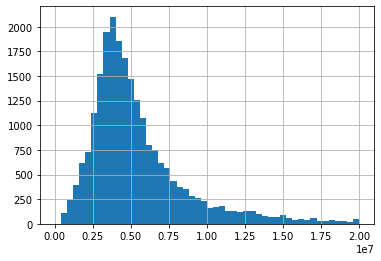

In [26]:
print(data['last_price'].describe())
data['last_price'].hist(bins = 50, range = (0,20000000))

(0, 20000000)

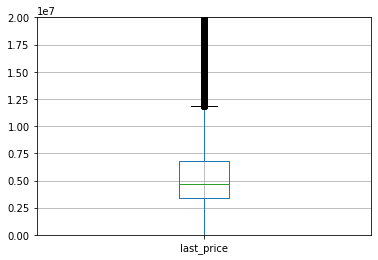

In [27]:
data.boxplot(column='last_price')

plt.ylim(0,20000000)

Найдём аномально дорогую недвижимость и добавим такой столбец

In [28]:
data['very_expensive'] = data['last_price'] > whiskers_position('last_price')[1]

3. Изучим данные по количеству комнат

count    23565.000000
mean         2.070656
std          1.078591
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64


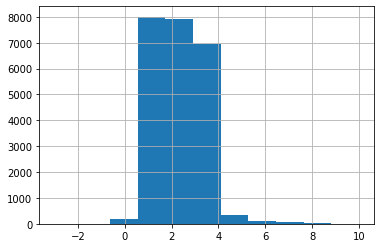

In [29]:
print(data['rooms'].describe())
data['rooms'].hist(bins = 11, range = (-3,10))

(-1, 20)

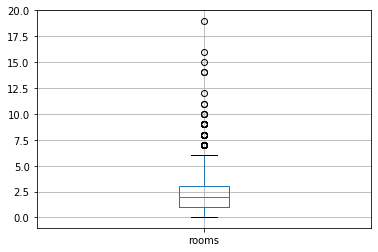

In [30]:
data.boxplot(column='rooms')

plt.ylim(-1,20)

Найдём аномалии по количеству комнат

In [31]:
data['bad_rooms'] = data['rooms'] > whiskers_position('rooms')[1]

4. Данные по высоте потолков

count    23565.000000
mean         2.735737
std          0.996999
min          1.000000
25%          2.550000
50%          2.650000
75%          2.750000
max        100.000000
Name: ceiling_height, dtype: float64


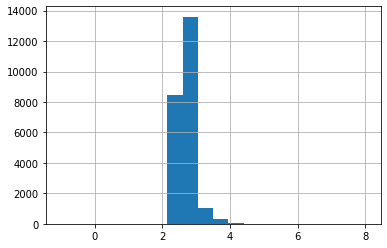

In [32]:
print(data['ceiling_height'].describe())

data['ceiling_height'].hist(bins = 20, range = (-1,8))

(1, 4)

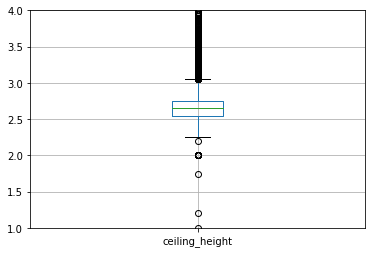

In [33]:
data.boxplot(column='ceiling_height')

plt.ylim(1,4)

Аномалии по высоте потолков

In [34]:
data['bad_ceiling'] = (data['ceiling_height'] > whiskers_position('ceiling_height')[1]) | (data['ceiling_height'] < whiskers_position('ceiling_height')[0])

5. Данные по сроку размещения объявлений

count    23565.000000
mean       169.203692
std        206.497729
min          1.000000
25%         45.000000
50%         95.000000
75%        198.000000
max       1580.000000
Name: days_exposition, dtype: float64


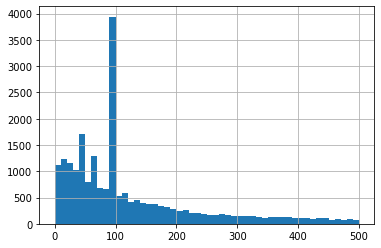

In [35]:
print(data['days_exposition'].describe())
data['days_exposition'].hist(bins = 50, range = (0,500))

(-200, 500)

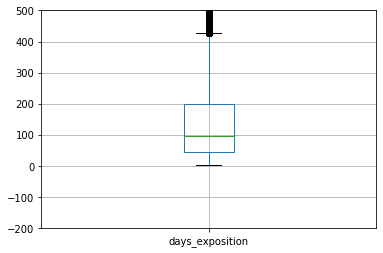

In [36]:
data.boxplot(column='days_exposition')

plt.ylim(-200,500)

In [37]:
print(whiskers_position('days_exposition'))




[-184.5, 427.5]


Так как положение "усов" зависит от величины межквартального размаха, а он в свою очередь очень большой у срока размещения, то левый "ус" в данном случае нам не будет полезен.  
Как показывает практика, на сделку по жилой недвижимости уходит в среднем от месяца и в совсем редких случаях это происходит быстрее. Часто клиентам нужно время на одобрение ипотеки, проверку документов и т.д.
Поэтому признаем аномальными все сделки, которые были заключены быстрее, чем за 30 дней.

In [38]:
data['very_slow'] = data['days_exposition'] > whiskers_position('days_exposition')[1]
data['very_fast'] = data['days_exposition'] < 30

#### Уберём редкие и выбивающиеся значения <a id="step4.1"></a>   
</div>

In [39]:
good_data = data[(data['bad_total_area'] == False) & 
     (data['very_expensive'] == False) &
     (data['bad_rooms'] == False) &
     (data['bad_ceiling'] == False) &
     (data['very_slow'] == False) &
     (data['very_fast'] == False)].reset_index(drop=True)

print('Доля чистых значений в датасете составила: {:.1%}'. format(len(good_data) / len(data)))
good_data.head(10)

Доля чистых значений в датасете составила: 65.3%


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,year,floor_category,living_area_ratio,kitchen_area_ratio,bad_total_area,very_expensive,bad_rooms,bad_ceiling,very_slow,very_fast
0,7,3350000.0,40.40,2018-12-04,1,2.75,11.0,18.60,1,False,...,2018,первый,0.460,0.272,False,False,False,False,False,False
1,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.00,13,False,...,2018,другой,0.320,0.410,False,False,False,False,False,False
2,10,2890000.0,30.40,2018-09-10,1,2.65,12.0,14.40,5,False,...,2018,другой,0.474,0.299,False,False,False,False,False,False
3,6,3700000.0,37.30,2017-11-02,1,2.66,26.0,10.60,6,False,...,2017,другой,0.284,0.386,False,False,False,False,False,False
4,5,7915000.0,71.60,2019-04-18,2,2.75,24.0,44.30,22,False,...,2019,другой,0.619,0.264,False,False,False,False,False,False
5,20,2900000.0,33.16,2018-05-23,1,2.70,27.0,15.43,26,False,...,2018,другой,0.465,0.266,False,False,False,False,False,False
6,18,5400000.0,61.00,2017-02-26,3,2.50,9.0,43.60,7,False,...,2017,другой,0.715,0.107,False,False,False,False,False,False
7,5,5050000.0,39.60,2017-11-16,1,2.67,12.0,20.30,3,False,...,2017,другой,0.513,0.215,False,False,False,False,False,False
8,10,3890000.0,54.00,2016-06-30,2,2.55,5.0,30.00,5,False,...,2016,последний,0.556,0.167,False,False,False,False,False,False
9,20,3550000.0,42.80,2017-07-01,2,2.56,5.0,27.00,5,False,...,2017,последний,0.631,0.121,False,False,False,False,False,False


Построим корреляцию между высотой потолков, ценой, количеством комнат и площадью

                ceiling_height  last_price     rooms  total_area
ceiling_height        1.000000    0.296608 -0.057293    0.170442
last_price            0.296608    1.000000  0.408028    0.677785
rooms                -0.057293    0.408028  1.000000    0.801383
total_area            0.170442    0.677785  0.801383    1.000000


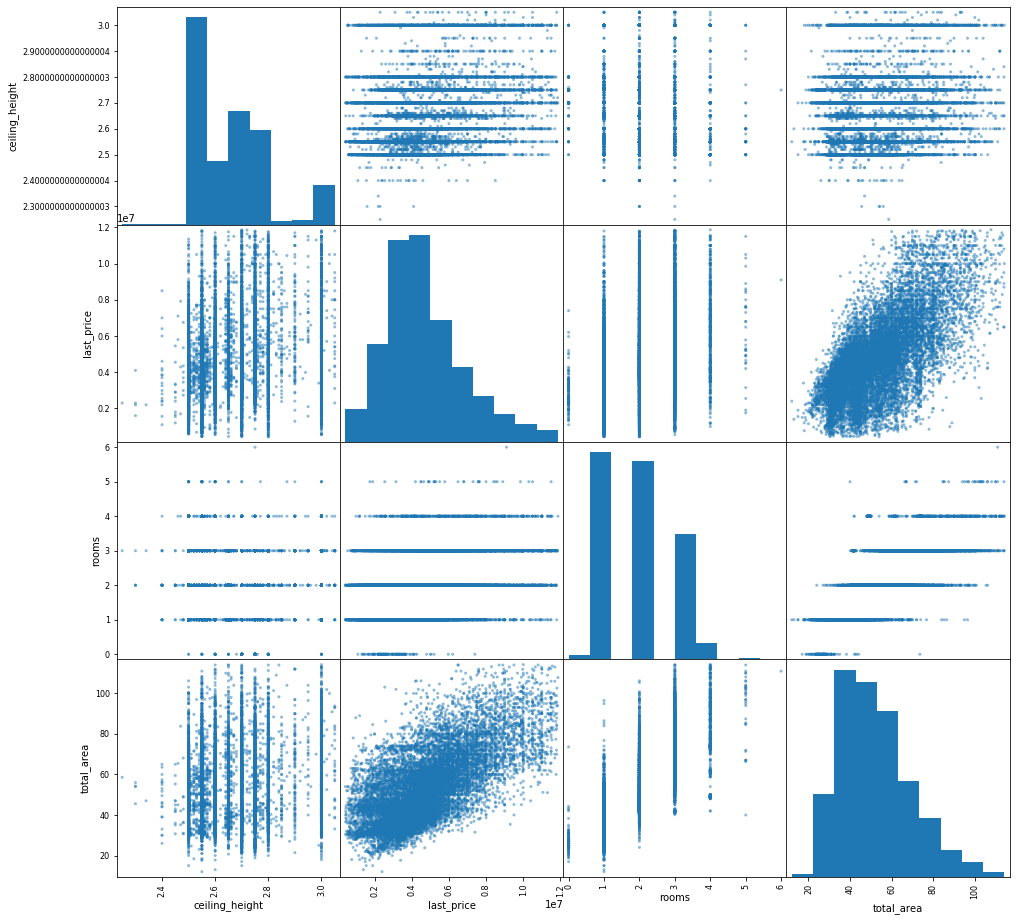

In [40]:
good_data_multi = good_data.pivot_table(index = good_data.index, values = ['total_area', 'last_price', 'rooms', 'ceiling_height'], aggfunc = 'mean')
pd.plotting.scatter_matrix(good_data_multi, figsize=(16, 16))
print(good_data_multi.corr())

### Вывод  <a id="step4.2"></a>   
</div>


*Характеристики "средней" квартиры:* 
1. Площадь - 52 кв. м;
2. Стоимость - 4,64 млн. рублей;  
3. Количество комнат - 2;
4. Высота потолков - 2,65 м.  

  
#### Средний срок размещения объявления для продажи квартиры: 95 дней (3 месяца)  

  
  
Выявленные аномалии
1. Площадь больше 114 кв. м;
2. Стоимость больше 11,9 млн рублей; 
3. Количество комнат 7 и больше;
4. Слишком низкие (2,25 кв. м и ниже) или слишком высокие (3,05 и более кв. м) потолки;
5. Срок размещения объявления меньше 30 дней и больше 427 дней, хотя исходя из практики, срок размещения длиннее 198 дней (4 квартиль) или иначе говоря почти полгода также можно признать аномальным.

  


### Факторы, влияющие на стоимость квартиры: <a id="step4.3"></a>   
</div>

            last_price     month   weekday      year
last_price    1.000000  0.009148 -0.015253  0.039867
month         0.009148  1.000000  0.004693 -0.298419
weekday      -0.015253  0.004693  1.000000 -0.004199
year          0.039867 -0.298419 -0.004199  1.000000

                     cityCenters_nearest  last_price  total_area
cityCenters_nearest             1.000000   -0.168364   -0.055728
last_price                     -0.168364    1.000000    0.677785
total_area                     -0.055728    0.677785    1.000000


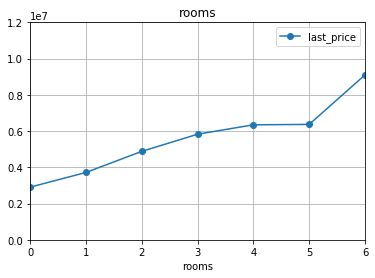

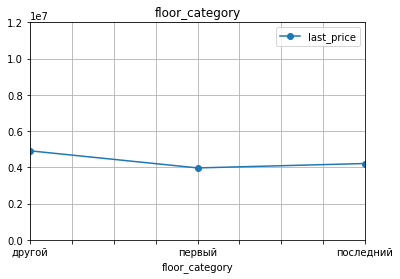

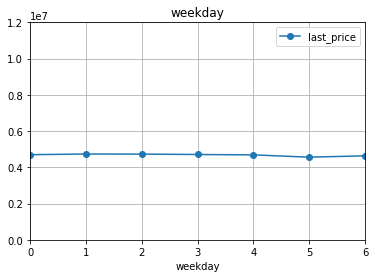

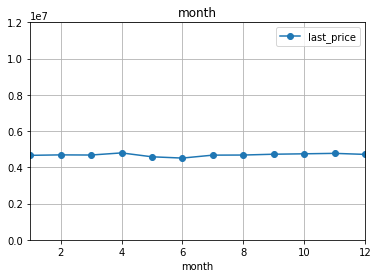

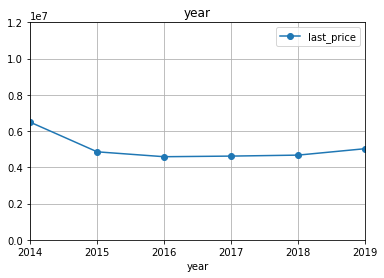

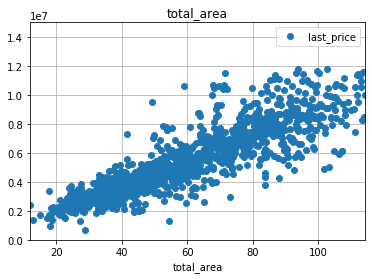

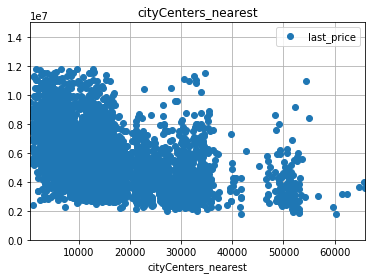

In [41]:
#С помощью циклов определим влияние разных факторов на стоимость квартиры
for column in ['rooms', 'floor_category', 'weekday', 'month', 'year']:
    price = good_data.pivot_table(index = column, values = 'last_price')
    price.plot(y='last_price', title = column, grid = True, style='-o', ylim = (0,12000000))
    
price_corr1 = good_data.pivot_table(index = good_data.index, values = ['last_price', 'weekday', 'month', 'year'], aggfunc = 'mean')
print(price_corr1.corr())
print()

for column in ['total_area', 'cityCenters_nearest']:
    price = good_data.pivot_table(index = column, values = 'last_price')
    price.plot(y='last_price', title = column, grid = True, style='o', ylim = (0,15000000))    
price_corr2 = good_data.pivot_table(index = good_data.index, values = ['last_price', 'total_area', 'cityCenters_nearest'])
print(price_corr2.corr()) 

### Вывод  <a id="step4.4"></a>   
</div>

Как видно из графиков и таблиц корреляции больше всего на стоимость объекта недвижимости влияет её площадь (что абсолютно логично).  
Расстояние от центра города и количество комнат  в ощутимой степени влияет на итоговую стоимость (что также совпадает с интуитивным ощущением).  
День размещения не влияет на объявление. С месяцем прослеживается незначительная корреляция, которая приблизительно совпадает с пиками активности клиентов на практике (сентябрь-декабрь и февраль-апрель активные для недвижимости месяца, а на майские праздники и лето количество сделок, а значит и цена, уменьшается).  
2014 год так всех напугал, что люди побежали покупать не только телевизоры, но и недвижимость, а спрос повышает цену. К нашему времени эта ситуация стала значительно более спокойной.  
Квартиры на первом и последнем этажах традиционно для нашей страны считаются "небезопасными" и менее комфортными, поэтому и имеют более низкую стоимость. 


### 10 населенных пунктов с наибольшим числом объявлений <a id="step4.5"></a>   
</div>

Построим сводную таблицы для стоимости за кв. м в зависимости от города размещения объявления.

In [42]:
median_price_per_sqm = good_data.pivot_table(index='locality_name', values='price_per_sqm', aggfunc=['count', 'median'])
median_price_per_sqm.columns = ['count', 'median']
median_price_per_sqm.sort_values('count', ascending=False).head(10)


,count,median
locality_name,,
Санкт-Петербург,9392,102147.0
посёлок Мурино,364,85714.0
посёлок Шушары,337,76585.0
Всеволожск,313,65854.0
Пушкин,250,98455.0
посёлок Парголово,248,91145.0
Колпино,237,74324.0
Гатчина,228,67417.5
деревня Кудрово,212,92225.0


In [43]:
median_top10 =  median_price_per_sqm.sort_values('count', ascending=False).head(10)
median_top10.sort_values('median')

,count,median
locality_name,,
Выборг,174,57392.5
Всеволожск,313,65854.0
Гатчина,228,67417.5
Колпино,237,74324.0
посёлок Шушары,337,76585.0
посёлок Мурино,364,85714.0
посёлок Парголово,248,91145.0
деревня Кудрово,212,92225.0
Пушкин,250,98455.0


Как видно из двух сводных таблиц выше, наибольшее число объявлений в Санкт-Петербурге. Северная столица лидирует с большим отрывом. Больше 300 объявлений в Мурино, Шушарах и Всеволожске.   
Самые дорогие квартиры по цене за кв. м в Санкт-Петербурге и Пушкине, а самые дешёвые в данной выборке в Выборге и Всеволожске.

### Исследование объявлений в Санкт-Петербурге <a id="step4.6"></a>   
</div>

Найдём центр Санкт-Петербурга

In [44]:
good_data['citycenters_km'] = round(good_data['cityCenters_nearest'] / 1000, 0)
good_data['citycenters_km'] = good_data['citycenters_km'].astype('int', errors='ignore')
good_data.loc[(good_data['locality_name'] == 'Санкт-Петербург') & (good_data['citycenters_km'].notna()), 'citycenters_km'].apply(round)
spb_good_data = good_data.query('locality_name == "Санкт-Петербург"')
spb_center = spb_good_data.pivot_table(index='citycenters_km', values=['price_per_sqm', 'last_price'], aggfunc='median')
spb_center.head(5)

,last_price,price_per_sqm
citycenters_km,,
0,6100000.0,126560.5
1,7750000.0,110178.0
2,7950000.0,112195.0
3,7370000.0,108000.0
4,7000000.0,111111.0


Зависимость цены от расстояния от центра Санкт-Петербурга


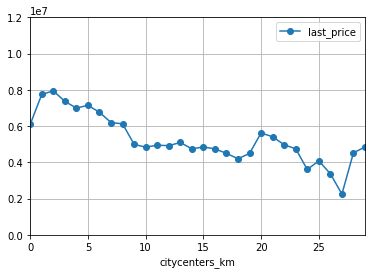

In [45]:
print('Зависимость цены от расстояния от центра Санкт-Петербурга')
spb_center.plot(y='last_price', grid = True, style='-o', ylim = (0,12000000))

Из графика видно, что ощутимое падение стоимости происходит на расстоянии между 6 и 7, а также 8 и 9 км. Визуально на 8 км бОльший скачок, поэтому за условный центр возьмем расстояние до 8 км включительно. 

In [46]:
spb_center = good_data[(good_data['citycenters_km'] <= 8) & (good_data['locality_name'] == 'Санкт-Петербург')]

In [47]:
# Методом describe смотрим на факторы площади, цены, количества комнат и высоты потолков для Санкт-Петербурга 
for column in ['total_area', 'last_price', 'rooms', 'ceiling_height']:
    print(column)
    print(spb_center[column].describe())
    print()
    


total_area
count    1468.000000
mean       61.269271
std        19.962747
min        12.000000
25%        45.075000
50%        59.600000
75%        75.000000
max       114.200000
Name: total_area, dtype: float64

last_price
count    1.468000e+03
mean     7.064107e+06
std      2.171197e+06
min      2.250000e+06
25%      5.400000e+06
50%      6.850000e+06
75%      8.600750e+06
max      1.186686e+07
Name: last_price, dtype: float64

rooms
count    1468.000000
mean        2.160082
std         0.923591
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         6.000000
Name: rooms, dtype: float64

ceiling_height
count    1468.000000
mean        2.762037
std         0.186336
min         2.400000
25%         2.550000
50%         2.750000
75%         3.000000
max         3.050000
Name: ceiling_height, dtype: float64



Построим гистограммы для каждого из факторов для центра Санкт-Петербурга

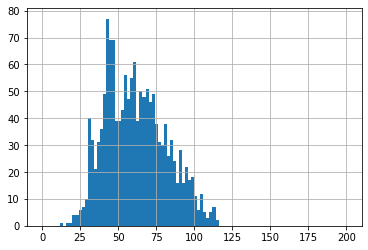

In [48]:
spb_center['total_area'].hist(bins = 100, range = (0,200))




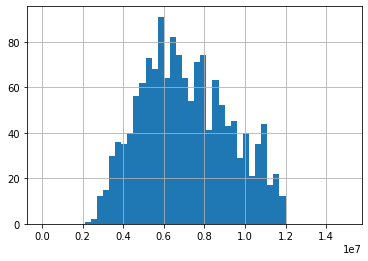

In [49]:
spb_center['last_price'].hist(bins = 50, range = (0,15000000))

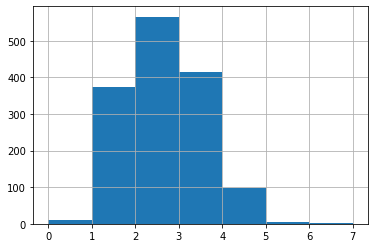

In [50]:
spb_center['rooms'].hist(bins = 7, range = (0,7))

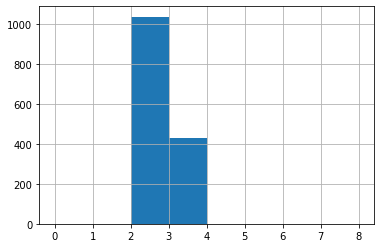

In [51]:
spb_center['ceiling_height'].hist(bins = 8, range = (0,8))

            last_price     month   weekday      year
last_price    1.000000  0.000283  0.030286  0.074492
month         0.000283  1.000000  0.057761 -0.295986
weekday       0.030286  0.057761  1.000000  0.013413
year          0.074492 -0.295986  0.013413  1.000000

                citycenters_km  last_price  total_area
citycenters_km        1.000000   -0.169545   -0.200057
last_price           -0.169545    1.000000    0.720007
total_area           -0.200057    0.720007    1.000000


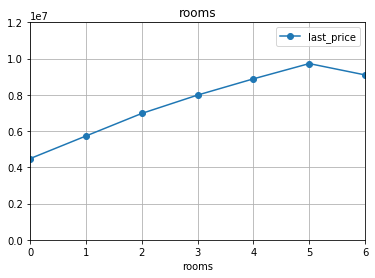

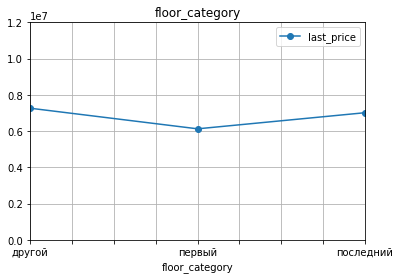

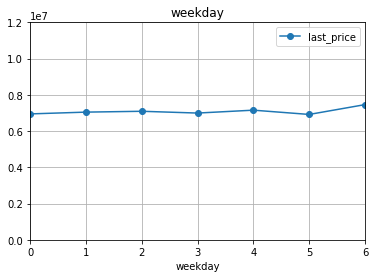

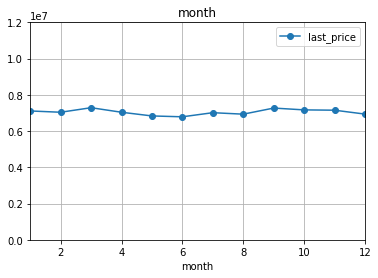

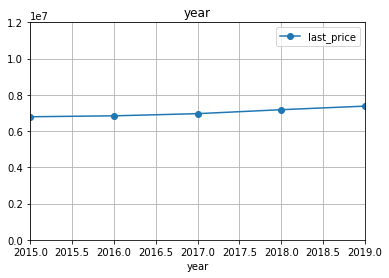

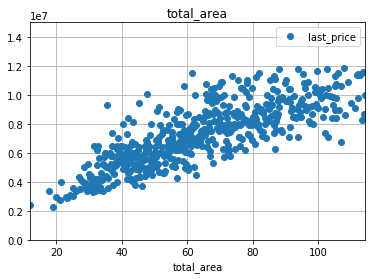

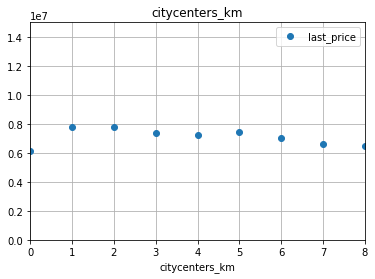

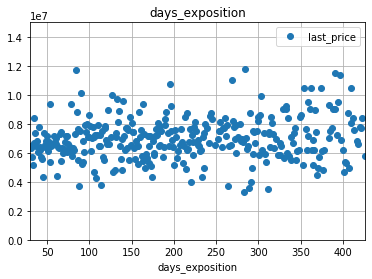

In [52]:
#С помощью циклов определим влияние разных факторов на стоимость квартиры в Санкт-Петербурге
for column in ['rooms', 'floor_category', 'weekday', 'month', 'year']:
    price = spb_center.pivot_table(index = column, values = 'last_price')
    price.plot(y='last_price', title = column, grid = True, style='-o', ylim = (0,12000000))
    
price_corr3 = spb_center.pivot_table(index = spb_center.index, values = ['last_price', 'weekday', 'month', 'year'], aggfunc = 'mean')
print(price_corr3.corr())
print()

for column in ['total_area', 'citycenters_km','days_exposition']:
    price = spb_center.pivot_table(index = column, values = 'last_price')
    price.plot(y='last_price', title = column, grid = True, style='o', ylim = (0,15000000))    
price_corr4 = spb_center.pivot_table(index = spb_center.index, values = ['last_price', 'total_area', 'citycenters_km'])
print(price_corr4.corr()) 

### Вывод <a id="step4.7"></a>   
</div>

В целом Санкт-Петербург подтверждает значения и по всему региону (рост от площади и количества комнат. Подтверждается и та логика, что чем дальше от центра, тем дешевле квартиры; квартиры на первых этажах дешевле как в городе, так и в регионе).   

*Характеристики "средней" квартиры в центре Санкт-Петербурге:* 
1. Площадь - 59,6 кв. м;
2. Стоимость - 6,85 млн. рублей;  
3. Количество комнат - 2;
4. Высота потолков - 2,75 м.    
#### Иными словами есть логичное увеличение всех основных характеристик квартиры.  

Есть и определенные особенности:
1. Нарастающая стоимость от 4-кк до 5-кк квартир. 
2. Также в Питере меньше боятся жить на последнем этаже (куда же без крыш Санкт-Петербурга).
3. Неожиданно дороже квартиры, которые размещаются на выходных днях (особенно в воскресенье).  
4. Есть небольшой скачок стоимости для объявлений данных в марте и сентябре. 

### Шаг 5. Общий вывод  <a id="step5"></a>   
</div>

Для определения рыночной стоимости объектов недвижимости можно выделить следующие параметры:  
1. Площадь квартиры;
2. Количество комнат;
3. Близость к центру города; 
4. Срок ожидания. (Может варьироваться, но в среднем на реализацию уходит около 100 дней)  
5. Этаж (не первый, и не последний).


В датасете были обнаружены ряд пропущенных значений и ошибок. Многие связаны с человеческим фактором (такие как высота потолков), для их исключения можно добавить ограничительные интервалы возможных значений. 
Несколько полей (балконы, является ли апартаментами) можно сделать обязательными к заполнению.  


Возможно, необходимо чуть лучше настроить систему определения удалённости квартиры от парков, водоёмов и других географических объектов, в данных полях фигурирует множество пропусков. Это может быть связано с тем, что каждый человек вводит адрес по-своему и система не может его определить (можно сделать обязательным выбор адреса из списка), также в самой базе данных могут не стоять метки для центров отдельных городов/посёлков региона и не отмечены все возможные водоёмы и парки.  

У Санкт-Петербурга прослеживаются свои особенности, описанные в выводе к шагу 4, но глобально он не сильно отличается от других городов региона.

Большинство анализируемых зависимостей подчиняется распределению Гаусса или Пуассона, что также указывает на правильность проведенного исследования. 